In [1]:
import pandas as pd 
import numpy as np
%pylab inline
matplotlib.rcParams['figure.figsize'] = [16, 8]
plt.rcParams.update({'font.size': 15})

AgentType = ["poorHigh","poorLow","richHigh","richLow"]
Beta_r = [0.01,0.02,0.03,0.04,0.05,0.06,0.07,0.08,0.09,0.10]
Gamma = [3.0, 4.0]

Populating the interactive namespace from numpy and matplotlib


In [2]:
# get the empirical part ready
Fdf = pd.read_csv("familyData.csv")
codes = {'employed':1, 'unemployed': 0, "retired": 0}
Fdf["employmentStatus"] = Fdf["employmentStatus"].map(codes)
codes = {'owner':1, 'renter': 0}
Fdf["ownership"] = Fdf["ownership"].map(codes)

years = [1999, 2001, 2003, 2005, 2007, 2009, 2011, 2013, 2015, 2017, 2019]
def outputVariables(waseozcbkhmType):
    output = []
    for i in range(waseozcbkhmType[0].shape[0]):
        output.append(np.concatenate((waseozcbkhmType[0][i],waseozcbkhmType[1][i],waseozcbkhmType[2][i],waseozcbkhmType[3][i]), axis = 1))
    return output

In [21]:
Fdf

,Unnamed: 0,familyID,year,composition,headCount,ageHead,liquidWealth,laborIncome,costPerPerson,totalExpense,...,employmentStatus,education,race,industry,ownership,skillLevel,financeExperience,ageGroup,decadeGroup,stockInvestmentRatio
0,0,3,1999,2,1,76,2.35,0.00,7.30,7.30,...,0,middleSchool,White,noneFinance,1,Low,No,60-80,1990s,0.000000
1,1,2,1999,0,4,47,0.00,26.14,4.17,16.68,...,1,highSchool,White,noneFinance,1,Low,No,40-60,1990s,0.399915
2,2,6129,1999,3,1,45,8.81,0.00,16.70,16.70,...,1,college,White,finance,1,High,Yes,40-60,1990s,0.018349
3,3,6944,1999,0,2,39,14.09,35.23,10.29,20.58,...,1,college,White,noneFinance,1,High,No,20-40,1990s,0.000000
4,4,3818,1999,4,4,34,0.00,48.85,4.45,17.80,...,1,highSchool,White,noneFinance,1,Low,No,20-40,1990s,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
66893,69687,2534,2019,1,4,39,0.00,9.18,4.27,17.08,...,0,college,Black,noneFinance,0,High,No,20-40,2010s,-0.000000
66894,69688,2162,2019,0,1,27,0.00,3.64,11.40,11.40,...,1,college,Black,noneFinance,0,High,No,20-40,2010s,0.000000
66895,69689,9011,2019,1,1,59,0.38,19.13,23.71,23.71,...,1,college,Black,noneFinance,0,High,No,40-60,2010s,0.000000
66896,69690,9317,2019,8,2,61,0.00,0.00,3.91,7.83,...,0,college,Black,finance,0,High,Yes,60-80,2010s,0.000000


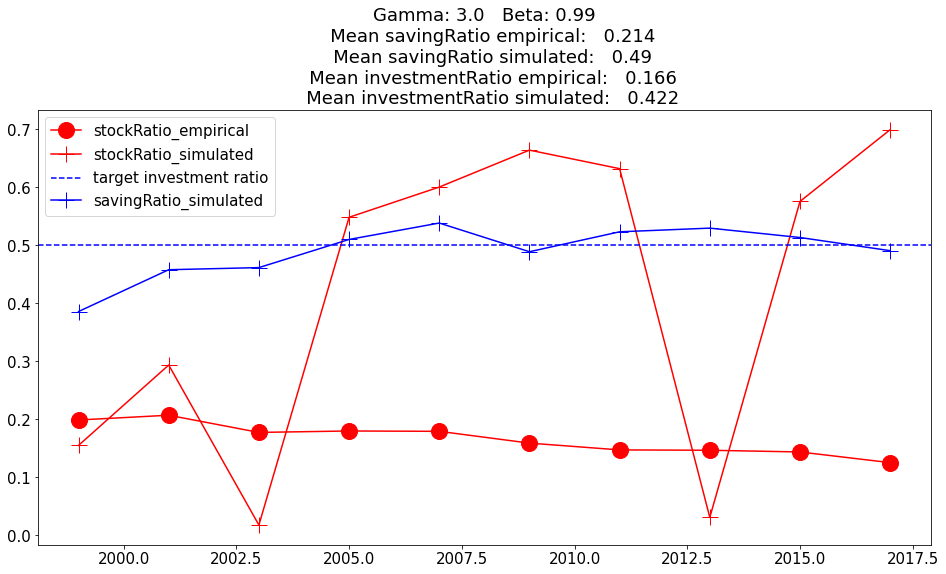

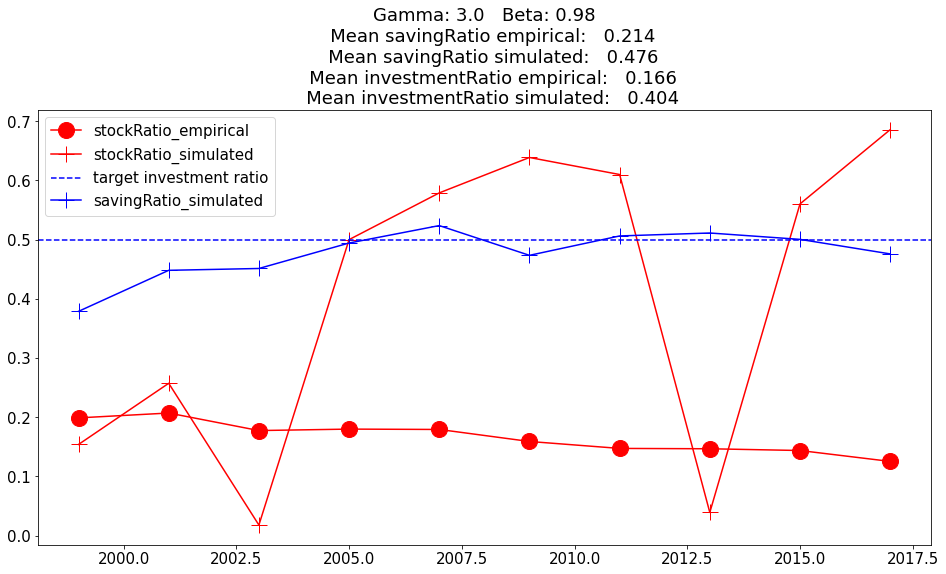

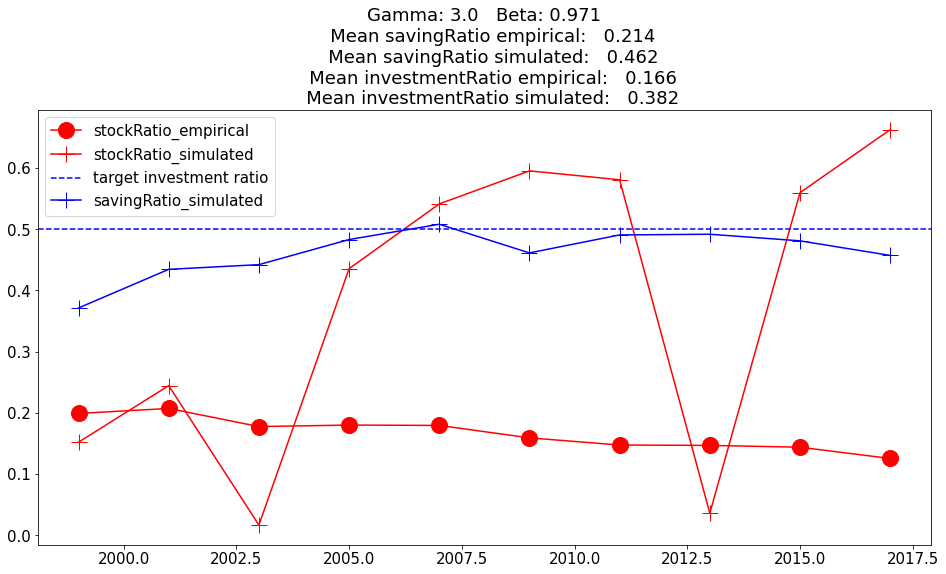

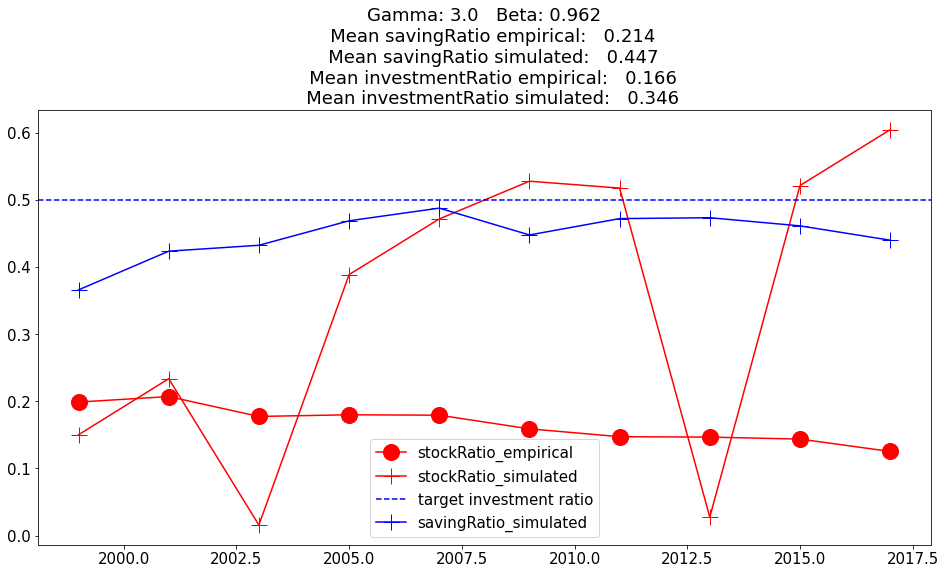

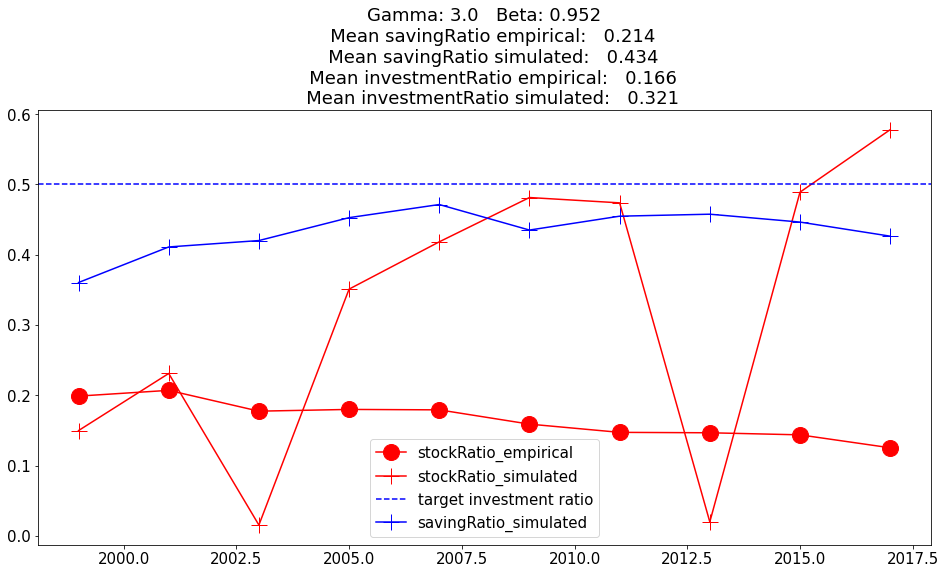

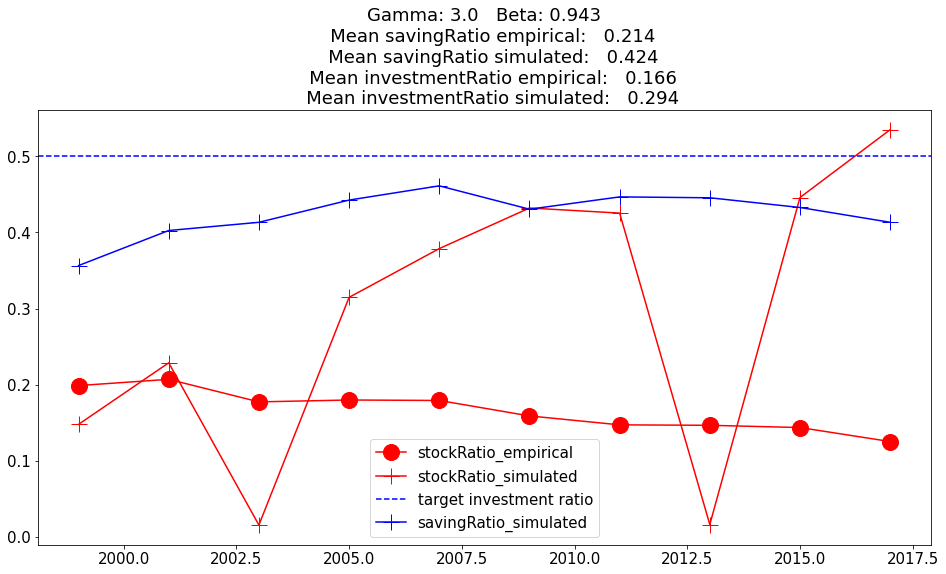

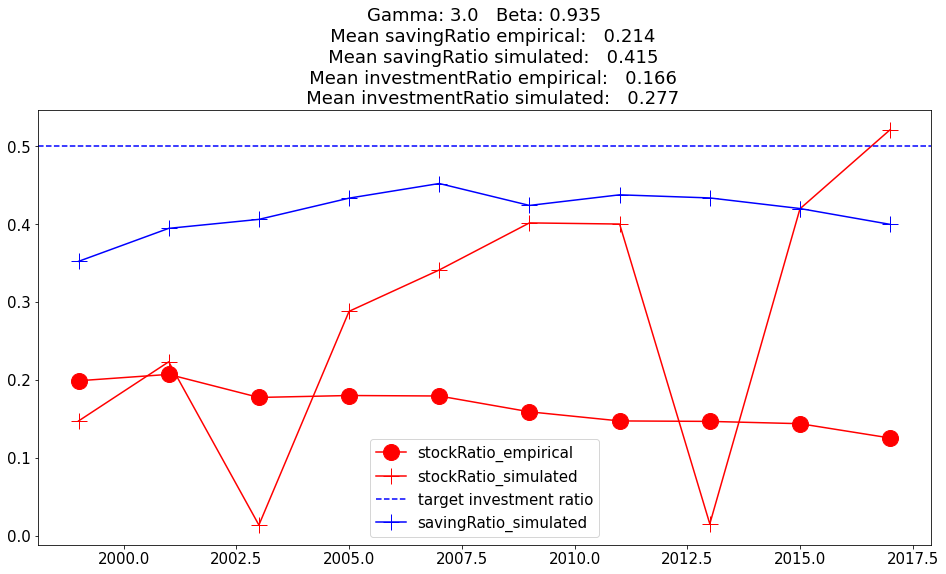

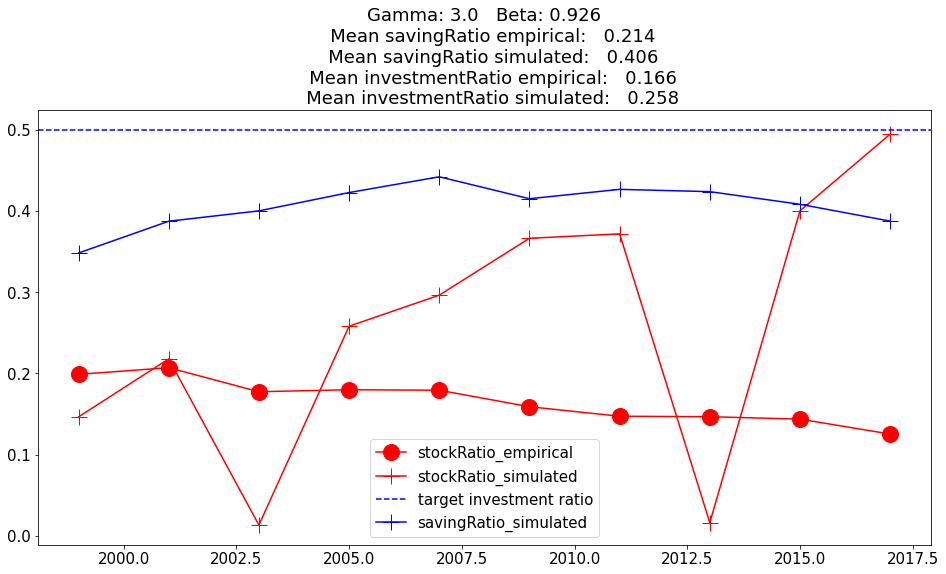

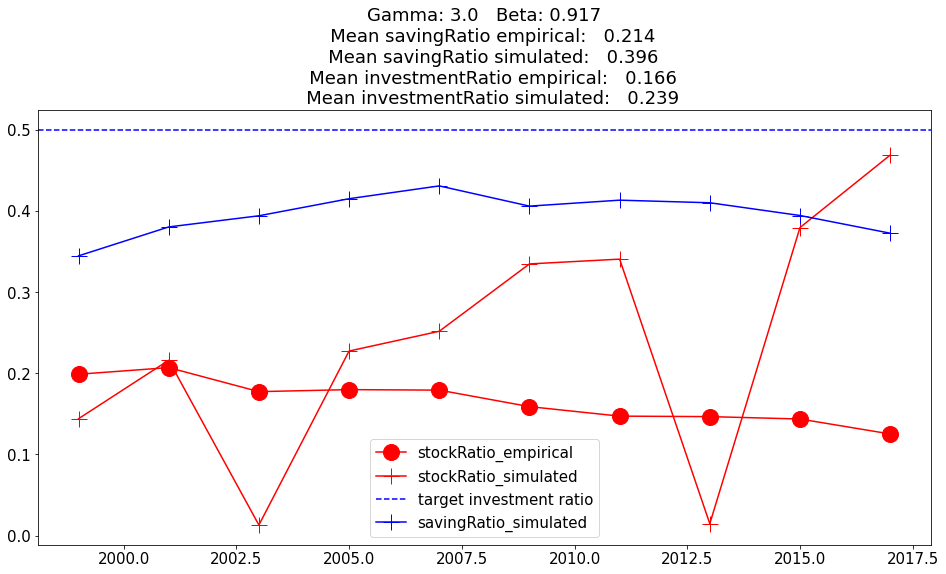

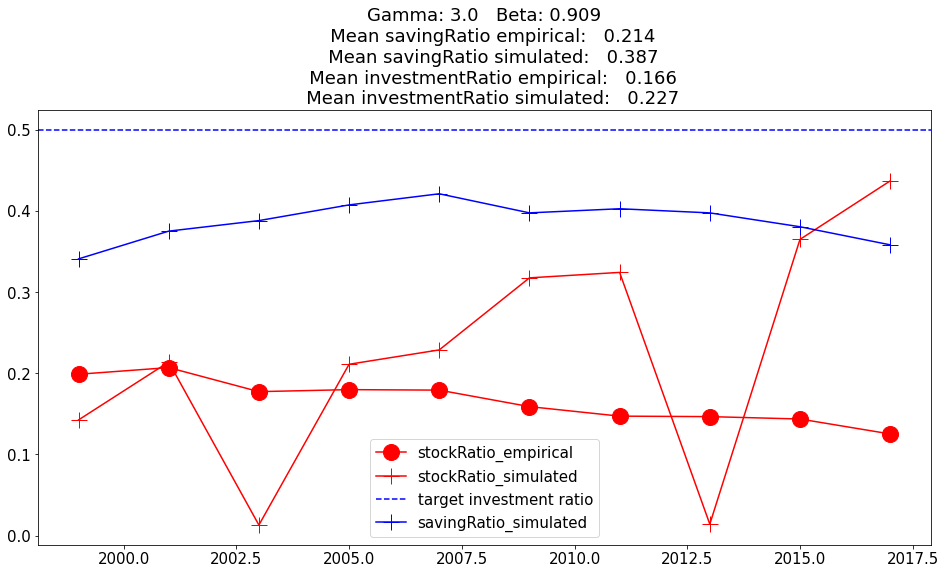

In [27]:
for gamma in Gamma:
    for beta_r in Beta_r:
        waseozcbkhmType = []
        for agentType in AgentType:
            ### load in the data 
            fileName = agentType + "_" + str(beta_r) + "_" + str(gamma)
            waseozcbkhmType.append(np.load("waseozcbkhm_" + fileName + ".npy", allow_pickle=True))
        waseozcbkhm = outputVariables(waseozcbkhmType)
        # [ws,ab,ss,es,os,zs,cs,bs,ks,hs,ms]
        wwww, aaaa, ssss, eeee, oooo, zzzz, cccc, bbbb, kkkk, hhhh, mmmm = waseozcbkhm
        # generate comparison plots between empirical and simulated variables
        plt.figure()
        stockRatio_empirical = []
        savingRatio_empirical = []
        stockRatio_simulated = []
        savingRatio_simulated = []
        for year in years[:-1]:  
            df = Fdf[(Fdf['year'] == year) & (Fdf['ageHead'] >= 30+(year-1999)) & (Fdf['ageHead'] <= 60 + (year - 1999))]
            stockRatio_empirical.append((df.investmentAmount / (df.liquidWealth + df.investmentAmount)).mean())
            savingRatio_empirical.append(((df.liquidWealth + df.investmentAmount)/(df.totalExpense + df.liquidWealth + df.investmentAmount)).mean())
            w = wwww[year - years[0],:]
            b = bbbb[year - years[0],:]
            k = kkkk[year - years[0],:]
            c = cccc[year - years[0],:]
            o = oooo[year - years[0],:]
            stockRatio_simulated.append((k/(b+k)).mean())
            savingRatio_simulated.append(((b+k)/((c+c*(3/7)*o)+b+k)).mean())
        meanSaving_empirical = round(np.mean(savingRatio_empirical), 3)
        meanInvestment_empirical = round(np.mean(stockRatio_empirical), 3)
        meanSaving_simulated = round(np.mean(savingRatio_simulated), 3)
        meanInvestment_simulated = round(np.mean(stockRatio_simulated), 3)
        plt.title("Gamma: " + str(gamma) +  "   Beta: " + str(round(1/(1+beta_r),3)) + 
                  "\n   Mean savingRatio empirical:   " + str(meanSaving_empirical) +
                  "\n   Mean savingRatio simulated:   " + str(meanSaving_simulated) +
                  "\n   Mean investmentRatio empirical:   " + str(meanInvestment_empirical) +
                  "\n   Mean investmentRatio simulated:   " + str(meanInvestment_simulated) 
                 )
        plt.plot(years[:-1], stockRatio_empirical, 'ro-', label = "stockRatio_empirical", markersize = 16)
        plt.plot(years[:-1], stockRatio_simulated, 'r+-', label = "stockRatio_simulated", markersize = 16)
        # plt.plot(years[:-1], savingRatio_empirical, 'bo-', label = "savingRatio_empirical", markersize = 16)
        plt.axhline(y=0.5, color='b', linestyle='--', label = "target investment ratio")
        plt.plot(years[:-1], savingRatio_simulated, 'b+-', label = "savingRatio_simulated", markersize = 16)
        plt.legend()

In [4]:
wealthLevel = []
consumption = []
investmentStock = []
bondOrcash = []
annuityAmount = []
participation = []
ownershipStatus = []
employment = []

for year in years:
    wealthLevel.append(Fdf[(Fdf['year'] == year) & (Fdf['ageHead'] >= 30+(year-1999)) & (Fdf['ageHead'] <= 60 + (year - 1999))]["wealthWithoutHomeEquity"].mean())
    investmentStock.append(Fdf[(Fdf['year'] == year) & (Fdf['ageHead'] >= 30+(year-1999)) & (Fdf['ageHead'] <= 60 + (year - 1999))]["investmentAmount"].mean())
    consumption.append(Fdf[(Fdf['year'] == year) & (Fdf['ageHead'] >= 30+(year-1999)) & (Fdf['ageHead'] <= 60 + (year - 1999))]["totalExpense"].mean())
    bondOrcash.append(Fdf[(Fdf['year'] == year) & (Fdf['ageHead'] >= 30+(year-1999)) & (Fdf['ageHead'] <= 60 + (year - 1999))]["liquidWealth"].mean())
    annuityAmount.append(Fdf[(Fdf['year'] == year) & (Fdf['ageHead'] >= 30+(year-1999)) & (Fdf['ageHead'] <= 60 + (year - 1999))]["annuityIRA"].mean())
    participation.append(Fdf[(Fdf['year'] == year) & (Fdf['ageHead'] >= 30+(year-1999)) & (Fdf['ageHead'] <= 60 + (year - 1999))]["participation"].mean())
    ownershipStatus.append(Fdf[(Fdf['year'] == year) & (Fdf['ageHead'] >= 30+(year-1999)) & (Fdf['ageHead'] <= 60 + (year - 1999))]["ownership"].mean())
    employment.append(Fdf[(Fdf['year'] == year) & (Fdf['ageHead'] >= 30+(year-1999)) & (Fdf['ageHead'] <= 60 + (year - 1999))]["employmentStatus"].mean())

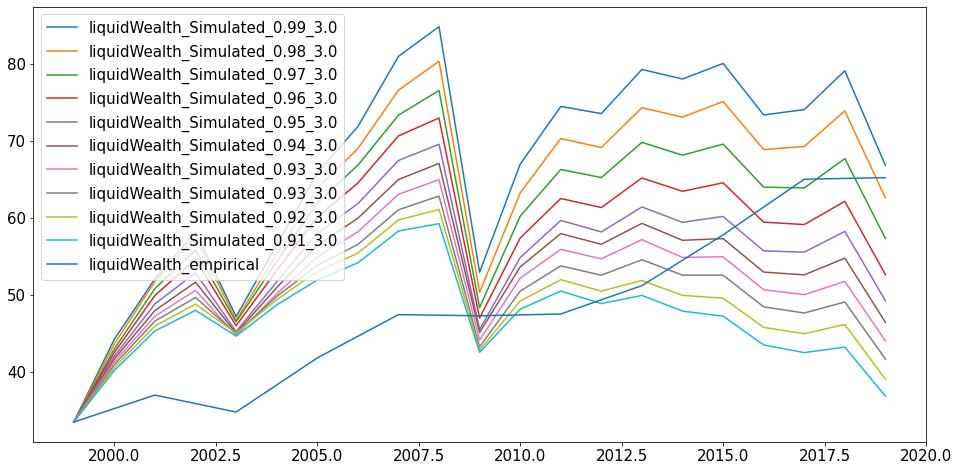

In [5]:
for gamma in Gamma:
    for beta_r in Beta_r:
        waseozcbkhmType = []
        for agentType in AgentType:
            ### load in the data 
            fileName = agentType + "_" + str(beta_r) + "_" + str(gamma)
            waseozcbkhmType.append(np.load("waseozcbkhm_" + fileName + ".npy", allow_pickle=True))
        waseozcbkhm = outputVariables(waseozcbkhmType)
        # [ws,ab,ss,es,os,zs,cs,bs,ks,hs,ms]
        wwww, aaaa, ssss, eeee, oooo, zzzz, cccc, bbbb, kkkk, hhhh, mmmm = waseozcbkhm
        plt.plot(range(1999,2020), wwww.mean(axis = 1), label = "liquidWealth_Simulated_" + str(round(1/(1+beta_r), 2)) + "_" + str(gamma))
plt.plot(years,np.array(investmentStock) + np.array(bondOrcash), label = "liquidWealth_empirical")
plt.legend()

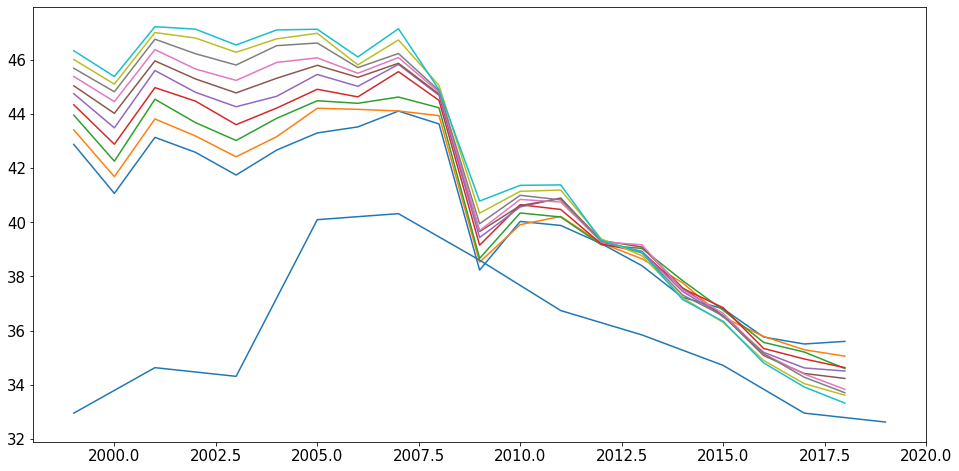

In [14]:
for gamma in Gamma:
    for beta_r in Beta_r:
        waseozcbkhmType = []
        for agentType in AgentType:
            ### load in the data 
            fileName = agentType + "_" + str(beta_r) + "_" + str(gamma)
            waseozcbkhmType.append(np.load("waseozcbkhm_" + fileName + ".npy", allow_pickle=True))
        waseozcbkhm = outputVariables(waseozcbkhmType)
        # [ws,ab,ss,es,os,zs,cs,bs,ks,hs,ms]
        wwww, aaaa, ssss, eeee, oooo, zzzz, cccc, bbbb, kkkk, hhhh, mmmm = waseozcbkhm
        plt.plot(range(1999,2019), cccc.mean(axis = 1), label = "consumption_Simulated_" + str(round(1/(1+beta_r), 2)) + "_" + str(gamma))
plt.plot(years,consumption, label = "consumption_empirical")
#plt.legend()

In [7]:
import numpy as np 
np.load("constant/c_bar.npy")

array([13.02238636, 13.75309091, 14.48379545, 15.2145    , 15.94520455,
       16.67590909, 17.32681818, 18.06886364, 18.71659091, 19.23181818,
       19.75068182, 20.18863636, 20.62727273, 20.94181818, 21.28886364,
       21.48477273, 21.64431818, 21.75659091, 21.76227273, 21.84340909,
       22.00159091, 21.95      , 22.00590909, 21.84      , 21.81090909,
       21.73181818, 21.68318182, 21.47272727, 21.3425    , 21.1775    ,
       20.92681818, 20.63022727, 20.38727273, 20.18204545, 20.02568182,
       19.83681818, 19.48227273, 19.26136364, 19.03909091, 18.82840909,
       18.58181818, 18.32772727, 17.97295455, 17.80204545, 17.42704545,
       17.185     , 16.83431818, 16.61136364, 16.17818182, 15.74318182,
       15.31636364, 14.86022727, 14.43045455, 14.02636364, 13.47977273,
       13.15386364, 12.67113636, 12.18840909, 11.70568182, 11.22295455,
       10.74022727])

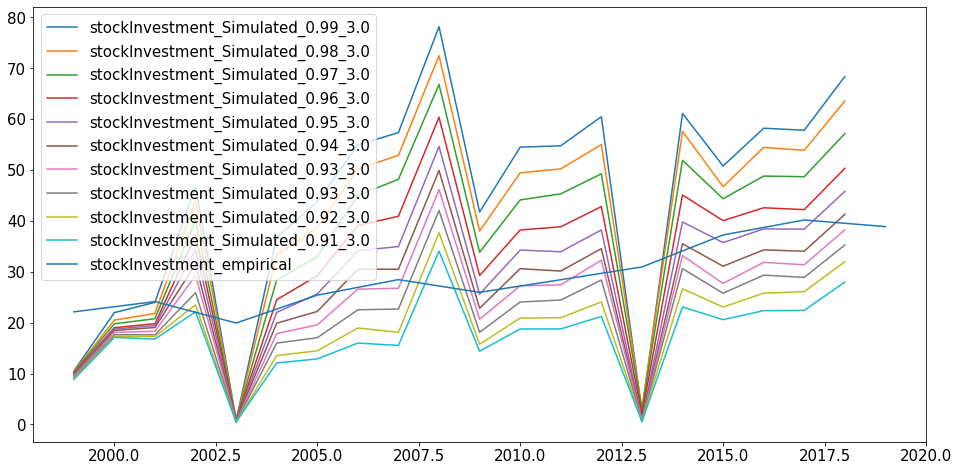

In [8]:
for gamma in Gamma:
    for beta_r in Beta_r:
        waseozcbkhmType = []
        for agentType in AgentType:
            ### load in the data 
            fileName = agentType + "_" + str(beta_r) + "_" + str(gamma)
            waseozcbkhmType.append(np.load("waseozcbkhm_" + fileName + ".npy", allow_pickle=True))
        waseozcbkhm = outputVariables(waseozcbkhmType)
        # [ws,ab,ss,es,os,zs,cs,bs,ks,hs,ms]
        wwww, aaaa, ssss, eeee, oooo, zzzz, cccc, bbbb, kkkk, hhhh, mmmm = waseozcbkhm
        plt.plot(range(1999,2019), kkkk.mean(axis = 1), label = "stockInvestment_Simulated_" + str(round(1/(1+beta_r), 2)) + "_" + str(gamma))
plt.plot(years,investmentStock, label = "stockInvestment_empirical")
plt.legend()

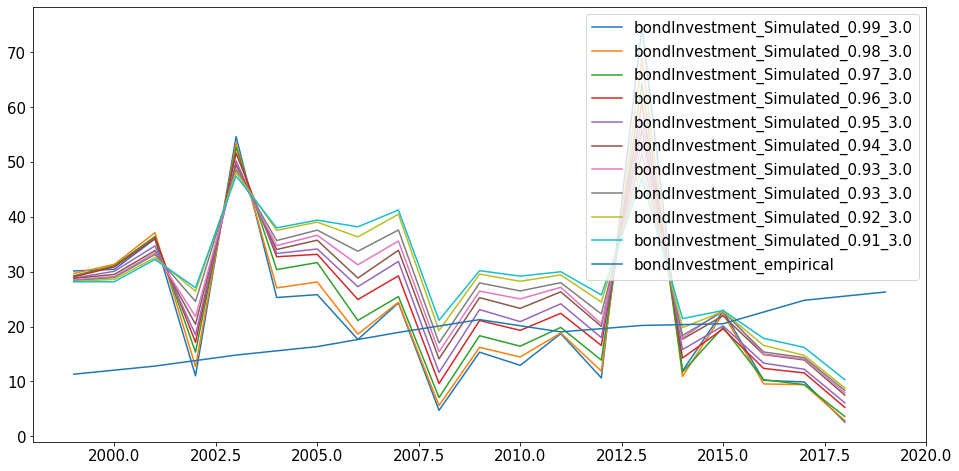

In [9]:
for gamma in Gamma:
    for beta_r in Beta_r:
        waseozcbkhmType = []
        for agentType in AgentType:
            ### load in the data 
            fileName = agentType + "_" + str(beta_r) + "_" + str(gamma)
            waseozcbkhmType.append(np.load("waseozcbkhm_" + fileName + ".npy", allow_pickle=True))
        waseozcbkhm = outputVariables(waseozcbkhmType)
        # [ws,ab,ss,es,os,zs,cs,bs,ks,hs,ms]
        wwww, aaaa, ssss, eeee, oooo, zzzz, cccc, bbbb, kkkk, hhhh, mmmm = waseozcbkhm
        plt.plot(range(1999,2019), bbbb.mean(axis = 1), label = "bondInvestment_Simulated_" + str(round(1/(1+beta_r), 2)) + "_" + str(gamma))
plt.plot(years,bondOrcash, label = "bondInvestment_empirical")
plt.legend()

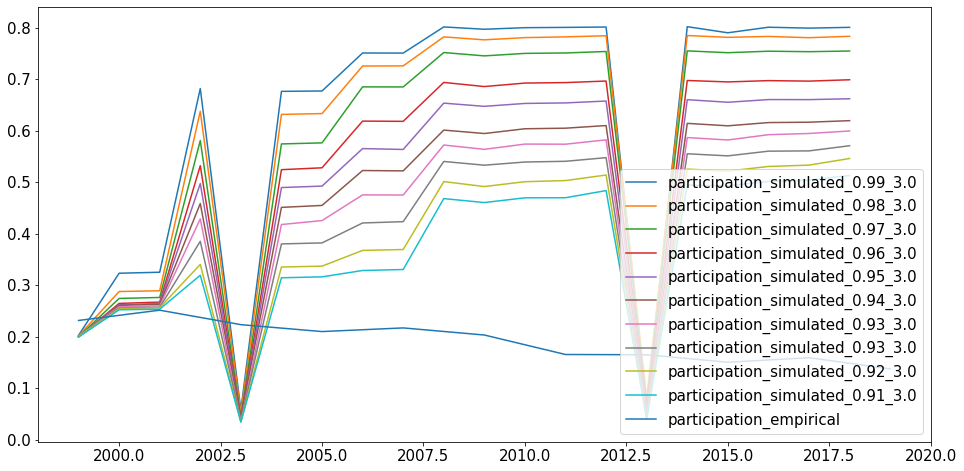

In [10]:
for gamma in Gamma:
    for beta_r in Beta_r:
        waseozcbkhmType = []
        for agentType in AgentType:
            ### load in the data 
            fileName = agentType + "_" + str(beta_r) + "_" + str(gamma)
            waseozcbkhmType.append(np.load("waseozcbkhm_" + fileName + ".npy", allow_pickle=True))
        waseozcbkhm = outputVariables(waseozcbkhmType)
        # [ws,ab,ss,es,os,zs,cs,bs,ks,hs,ms]
        wwww, aaaa, ssss, eeee, oooo, zzzz, cccc, bbbb, kkkk, hhhh, mmmm = waseozcbkhm
        plt.plot(range(1999,2019), (kkkk>0).mean(axis = 1), label = "participation_simulated_" + str(round(1/(1+beta_r), 2)) + "_" + str(gamma))
plt.plot(years,participation, label = "participation_empirical")
plt.legend()

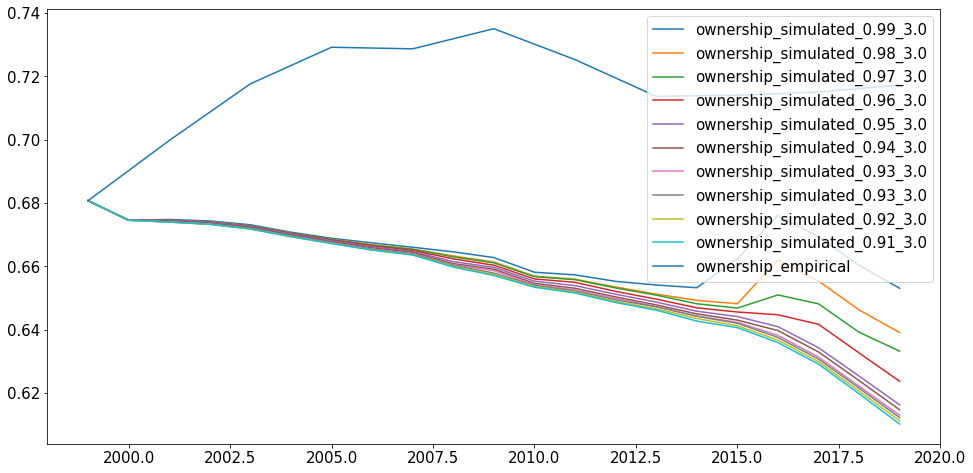

In [11]:
for gamma in Gamma:
    for beta_r in Beta_r:
        waseozcbkhmType = []
        for agentType in AgentType:
            ### load in the data 
            fileName = agentType + "_" + str(beta_r) + "_" + str(gamma)
            waseozcbkhmType.append(np.load("waseozcbkhm_" + fileName + ".npy", allow_pickle=True))
        waseozcbkhm = outputVariables(waseozcbkhmType)
        # [ws,ab,ss,es,os,zs,cs,bs,ks,hs,ms]
        wwww, aaaa, ssss, eeee, oooo, zzzz, cccc, bbbb, kkkk, hhhh, mmmm = waseozcbkhm
        plt.plot(range(1999,2020), oooo.mean(axis = 1), label = "ownership_simulated_" + str(round(1/(1+beta_r), 2)) + "_" + str(gamma))
plt.plot(years,ownershipStatus, label = "ownership_empirical")
plt.legend()

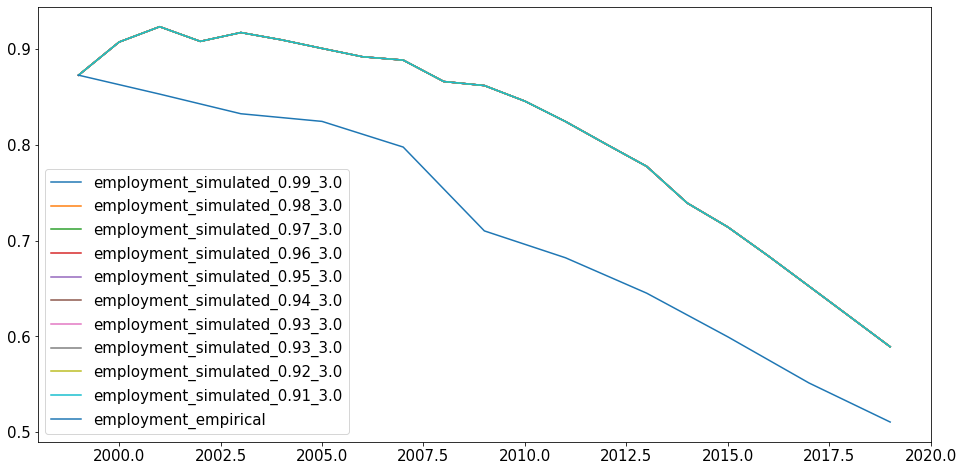

In [12]:
for gamma in Gamma:
    for beta_r in Beta_r:
        waseozcbkhmType = []
        for agentType in AgentType:
            ### load in the data 
            fileName = agentType + "_" + str(beta_r) + "_" + str(gamma)
            waseozcbkhmType.append(np.load("waseozcbkhm_" + fileName + ".npy", allow_pickle=True))
        waseozcbkhm = outputVariables(waseozcbkhmType)
        # [ws,ab,ss,es,os,zs,cs,bs,ks,hs,ms]
        wwww, aaaa, ssss, eeee, oooo, zzzz, cccc, bbbb, kkkk, hhhh, mmmm = waseozcbkhm
        plt.plot(range(1999,2020), eeee.mean(axis = 1), label = "employment_simulated_" + str(round(1/(1+beta_r), 2)) + "_" + str(gamma))
# fix here the retirment people is unemployed. 
plt.plot(years,employment, label = "employment_empirical")
plt.legend()

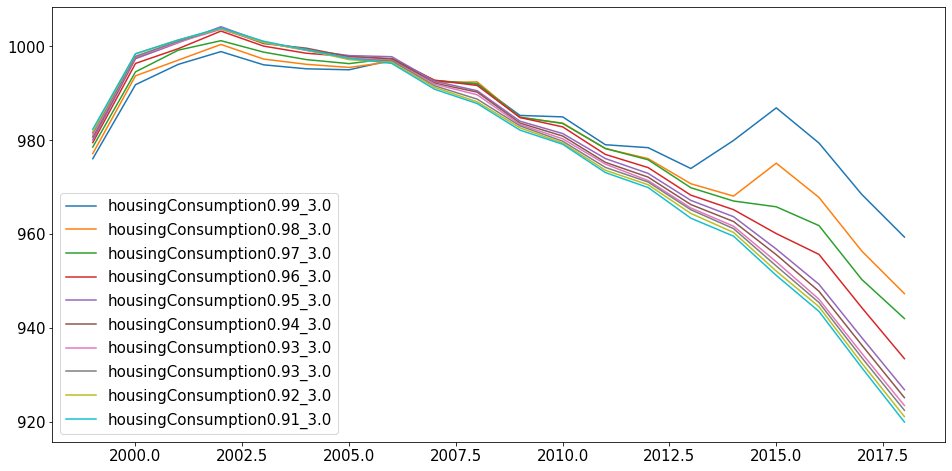

In [13]:
for gamma in Gamma:
    for beta_r in Beta_r:
        waseozcbkhmType = []
        for agentType in AgentType:
            ### load in the data 
            fileName = agentType + "_" + str(beta_r) + "_" + str(gamma)
            waseozcbkhmType.append(np.load("waseozcbkhm_" + fileName + ".npy", allow_pickle=True))
        waseozcbkhm = outputVariables(waseozcbkhmType)
        # [ws,ab,ss,es,os,zs,cs,bs,ks,hs,ms]
        wwww, aaaa, ssss, eeee, oooo, zzzz, cccc, bbbb, kkkk, hhhh, mmmm = waseozcbkhm
        plt.plot(range(1999,2019), hhhh.mean(axis = 1), label = "housingConsumption" + str(round(1/(1+beta_r), 2)) + "_" + str(gamma))
plt.legend()